In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import re
import requests
pd.options.display.max_rows = 5000 

In [2]:
import requests

url = "https://yahoo-finance15.p.rapidapi.com/api/yahoo/hi/history/irr.l/1d"

headers = {
    'x-rapidapi-key': "9cd97ba3camsh244cbd2e3e420a4p1e83c0jsne0fdd0787f8e",
    'x-rapidapi-host': "yahoo-finance15.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers)

print(response.text)

{
    "meta": {
        "currency": "GBp",
        "symbol": "IRR.L",
        "exchangeName": "LSE",
        "instrumentType": "EQUITY",
        "firstTradeDate": 1423728000,
        "regularMarketTime": 1628180245,
        "gmtoffset": 3600,
        "timezone": "BST",
        "exchangeTimezoneName": "Europe/London",
        "regularMarketPrice": 23.2,
        "chartPreviousClose": 10.75,
        "priceHint": 2,
        "dataGranularity": "1d",
        "range": ""
    },
    "items": {
        "1423728000": {
            "date": "12-02-2015",
            "open": 10.5,
            "high": 10.5,
            "low": 10.5,
            "close": 10.75,
            "adjclose": 10.75
        },
        "1423814400": {
            "date": "13-02-2015",
            "open": 10.1,
            "high": 10.1,
            "low": 8,
            "close": 8.25,
            "adjclose": 8.25
        },
        "1424073600": {
            "date": "16-02-2015",
            "open": 8,
            "high": 8,
  

In [3]:
string = response.text

In [4]:
string[:1000]

'{\n    "meta": {\n        "currency": "GBp",\n        "symbol": "IRR.L",\n        "exchangeName": "LSE",\n        "instrumentType": "EQUITY",\n        "firstTradeDate": 1423728000,\n        "regularMarketTime": 1628180245,\n        "gmtoffset": 3600,\n        "timezone": "BST",\n        "exchangeTimezoneName": "Europe/London",\n        "regularMarketPrice": 23.2,\n        "chartPreviousClose": 10.75,\n        "priceHint": 2,\n        "dataGranularity": "1d",\n        "range": ""\n    },\n    "items": {\n        "1423728000": {\n            "date": "12-02-2015",\n            "open": 10.5,\n            "high": 10.5,\n            "low": 10.5,\n            "close": 10.75,\n            "adjclose": 10.75\n        },\n        "1423814400": {\n            "date": "13-02-2015",\n            "open": 10.1,\n            "high": 10.1,\n            "low": 8,\n            "close": 8.25,\n            "adjclose": 8.25\n        },\n        "1424073600": {\n            "date": "16-02-2015",\n           

- 获取日期data

In [5]:
def get_dates(string):
    date = re.compile('"date":((.*),)')
    date = date.findall(string)
    date = [i[0][2:12] for i in date]
    date = [datetime.strptime(i, "%d-%m-%Y").strftime("%Y-%m-%d") for i in date]
    return date

In [6]:
date = get_dates(string)
print( date[:5] )

['2015-02-12', '2015-02-13', '2015-02-16', '2015-02-17', '2015-02-18']


- 获取close价格

In [7]:
def get_close(string):
    close = re.compile('"close":((.*),)')
    close = close.findall(string)
    close = [float(i[1].strip()) for i in close]
    return close

In [8]:
close = get_close(string)
close[:5]

[10.75, 8.25, 7.5, 7.5, 7.5]

In [12]:
print(len(close))
print(len(date[2:]))

1637
1637


- form dataframe

In [13]:
def form_df(date, close, col_name1, col_name2):
    return pd.DataFrame({col_name1:date[2:], col_name2:close })

In [18]:
irr = form_df(date, close, 'date', 'irr_close')
irr.set_index('date', drop=True, inplace=True)
irr.tail(3)

,irr_close
date,
2021-08-03,21.4
2021-08-04,22.9
2021-08-05,23.2


- save dataframe as csv

- IPO and Placing info

In [15]:
p1_sprice = 7
p1_wprice = 12
p1_date = '2020-05-01'
p1_swratio = 1/1
# p2_sprice = 2.3
# p2_wprice = 3
# p2_date = '2020-09-01'
# p2_swratio = 1/1

#### 技巧：没有数值的Entry设置成None的话，它们就不参与之后的计算。省很多事儿。

In [19]:
irr['p1_sprice'] = [p1_sprice if i  >= p1_date else None for i in irr.index]
irr['p1_wprice'] = [p1_wprice if i  >= p1_date else None for i in irr.index]

# irr['p2_sprice'] = [p2_sprice if i  >= p2_date else None for i in irr.index]
# irr['p2_wprice'] = [p2_wprice if i  >= p2_date else None for i in irr.index]

- If each Placing or IPO investor invest 10000 pounds ever time, what are the positions look like？

In [20]:
fund = 10000
split = 1

In [21]:
irr['p1_sposition'] = [round(fund/split/p1_sprice,2) if i >= p1_date else 0 for i in irr.index]
irr['p1_wposition'] = irr['p1_sposition']*p1_swratio


# irr['p2_sposition'] = [round(fund/split/p2_sprice,2) if i >= p2_date else 0 for i in irr.index]
# irr['p2_wposition'] = irr['p2_sposition']*p2_swratio

- What is the profit looks like， respectively?

In [23]:
# Profit from the shares, 

irr['p1_sprft'] = irr.irr_close - irr['p1_sprice']

# irr['p2_sprft'] = irr.irr_close - irr['p2_sprice']

In [24]:
# Profit from the warranties

p1_wprofit = []
for i,j in zip(irr.irr_close, irr['p1_wprice']):
    if i - j >0:
        p1_wprofit.append(round(i-j,2))
    else:
        p1_wprofit.append(0)

irr['p1_wprft'] = p1_wprofit

# p2_wprofit = []
# for i,j in zip(irr.irr_close, irr['p2_wprice']):
#     if i - j >0:
#         p2_wprofit.append(round(i-j,2))
#     else:
#         p2_wprofit.append(0)

# irr['p2_wprft'] = p2_wprofit

In [25]:
irr = irr.fillna(0)

irr

,irr_close,p1_sprice,p1_wprice,p1_sposition,p1_wposition,p1_sprft,p1_wprft
date,,,,,,,
2015-02-16,10.75,0.0,0.0,0.00,0.00,0.00,0.00
2015-02-17,8.25,0.0,0.0,0.00,0.00,0.00,0.00
2015-02-18,7.50,0.0,0.0,0.00,0.00,0.00,0.00
2015-02-19,7.50,0.0,0.0,0.00,0.00,0.00,0.00
2015-02-20,7.50,0.0,0.0,0.00,0.00,0.00,0.00
2015-02-23,7.63,0.0,0.0,0.00,0.00,0.00,0.00
2015-02-24,7.63,0.0,0.0,0.00,0.00,0.00,0.00
2015-02-25,7.63,0.0,0.0,0.00,0.00,0.00,0.00
2015-02-26,7.63,0.0,0.0,0.00,0.00,0.00,0.00


- Total Profit per share

In [32]:
irr['prft_per_share'] = irr['p1_sprft']+irr['p1_wprft']
irr['p1_10k_rtn'] = irr['p1_sposition']*irr['p1_sprft']+irr['p1_wposition']*irr['p1_wprft']
# irr['p2_10k_rtn'] = irr['p2_sposition']*irr['p2_sprft']+irr['p2_wposition']*irr['p2_wprft']
irr['total_rtn'] = irr['p1_10k_rtn']

In [33]:
irr

,irr_close,p1_sprice,p1_wprice,p1_sposition,p1_wposition,p1_sprft,p1_wprft,prft_per_share,p1_10k_rtn,total_rtn
date,,,,,,,,,,
2015-02-16,10.75,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000
2015-02-17,8.25,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000
2015-02-18,7.50,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000
2015-02-19,7.50,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000
2015-02-20,7.50,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000
2015-02-23,7.63,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000
2015-02-24,7.63,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000
2015-02-25,7.63,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000
2015-02-26,7.63,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000


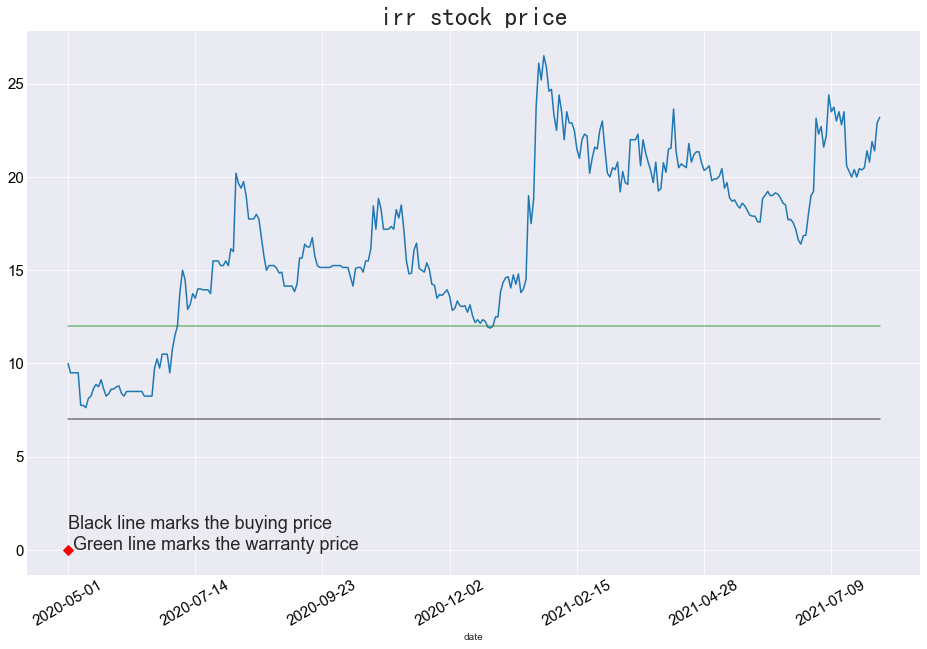

In [49]:
title = 'irr stock price'
plt.figure(figsize=(16,10))
plt.style.use('seaborn-darkgrid')
irr.irr_close[irr.index>=p1_date].plot()
irr.p1_sprice[irr.index>=p1_date].plot(color='k', alpha=0.5)
irr.p1_wprice[irr.index>=p1_date].plot(color='g', alpha=0.5)
plt.scatter(p1_date, 0, color='r', marker='D', s=50)
plt.text(p1_date, 0, 'Black line marks the buying price \n Green line marks the warranty price', fontsize=18)
plt.yticks(fontsize=15,color='k')
plt.xticks( fontsize=15,color='k', rotation=30)
plt.title('{}'.format(title), fontproperties = 'SimHei',fontsize=25)
# plt.legend(('p1_profit','p2_profit'),loc="upper left", fontsize=20 );
plt.savefig('{}'.format(title),dpi=300,bbox_inches ='tight',pad_inches = 1,transparent = True,orientation ='landscape')
plt.show()

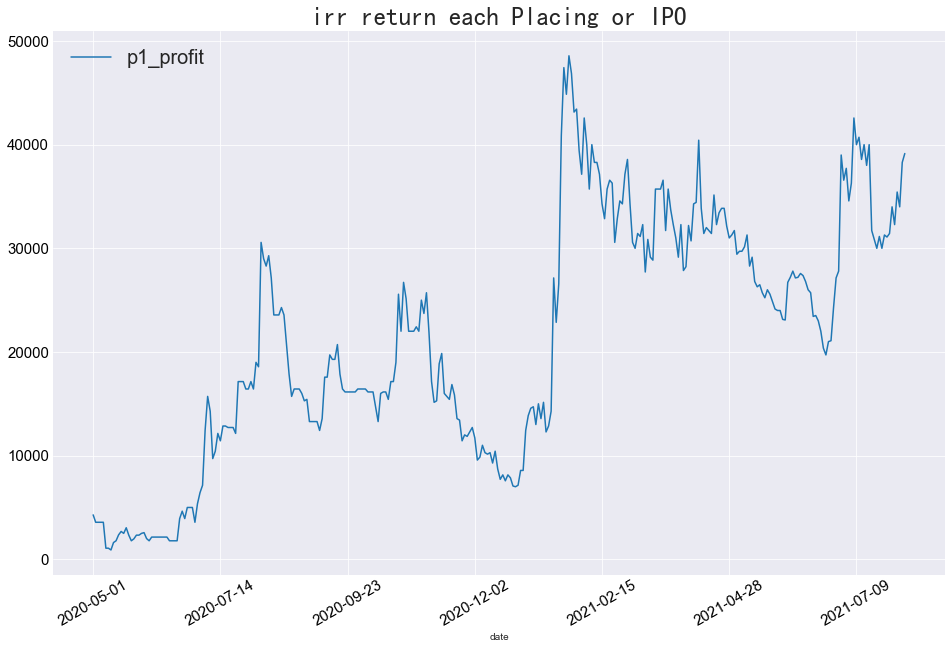

In [50]:
title = 'irr return each Placing or IPO'
plt.figure(figsize=(16,10))
plt.style.use('seaborn-darkgrid')
irr.p1_10k_rtn[irr.index>=p1_date].plot()
plt.yticks(fontsize=15,color='k')
plt.xticks( fontsize=15,color='k', rotation=30)
plt.title('{}'.format(title), fontproperties = 'SimHei',fontsize=25)
plt.legend((['p1_profit']),loc="upper left", fontsize=20 );
plt.savefig('{}'.format(title),dpi=300,bbox_inches ='tight',pad_inches = 1,transparent = True,orientation ='landscape')
plt.show()

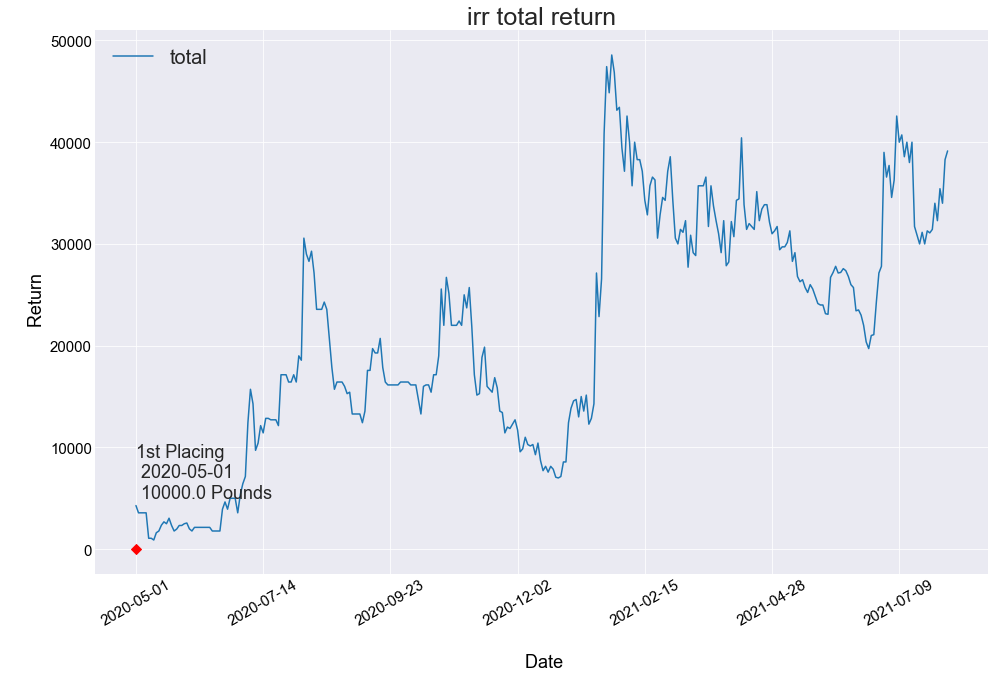

In [46]:
title = 'irr total return'
plt.figure(figsize=(16,10))
plt.style.use('seaborn-darkgrid')
# irr.loc[irr.index >= p1_date].p1_10k_rtn.plot()
# irr.loc[irr.index >= p1_date].p2_10k_rtn.plot(color='r', alpha=0.8)
irr.loc[irr.index >= p1_date].total_rtn.plot()
plt.text(p1_date, 0+5000, '1st Placing \n {} \n {} Pounds'.format(p1_date, fund/split), fontsize=18)
# plt.text(p2_date, 0+500, '2nd Placing \n {} \n {} Pounds'.format(p2_date, fund/split), fontsize=18)
plt.scatter(p1_date, 0, color='r', marker='D', s=50)
# plt.scatter(p2_date, 0, color='r', marker='D', s=50)
plt.yticks(fontsize=15,color='k')
plt.xticks( fontsize=15,color='k', rotation=30)
plt.title('{}'.format(title), fontsize=25)
plt.legend(['total'],loc="upper left", fontsize=20 )
plt.ylabel('\n Return', fontsize=18, color='k')
plt.xlabel('\n Date', fontsize=18,color='k')
plt.savefig('{}'.format(title),dpi=300,bbox_inches ='tight',pad_inches = 1,transparent = True,orientation ='landscape')

plt.show()

In [184]:
pwd

'/Users/paxton615/Github_Personal/Notes/Notes/Financial_models/SI Stocks'

In [ ]:
cobr.to_csv(r'/Users/paxton615/Desktop/cobr.csv')